In [103]:
import csv
from sklearn import svm
import numpy as np
import Loader
import tensorflow as tf
import Transformer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)
classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)

In [104]:
def getSubsets(xRemain, yRemain, percentGap):
    initLength = len(xRemain)
    finArr = []
    curPercent = percentGap
    while curPercent < 1:
        
        (Xtrain,xRemain,Ytrain,yRemain) = model_selection.train_test_split(xRemain, yRemain, test_size= 1 - initLength / len(xRemain)  * percentGap)
        #print(initLength / len(xRemain)  * percentGap, len(Xtrain), len(xRemain) / initLength )
        curPercent += percentGap
        finArr.append([Xtrain, Ytrain])
    return finArr

In [105]:
mc = ModelCheckpoint('AddingPLANN.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

subsets = getSubsets(compoundDataTrain, classTrain, .1)
curX = subsets[0][0]
curY = subsets[0][1]

l1Reg = keras.regularizers.L1(.001)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)


labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  curX, 
                                                        compoundDataTest, compoundDataValidate,
                                                        endDims=[1,1,9,4,6,7,3,16], muted = True)

labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

#after transformations are done assign data
dataLabels = labelsMaxPCA
trainData = trainMaxPCA
testData = testMaxPCA
valData = valMaxPCA

Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

accuracy = 0
while(accuracy < .7):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(2)
    ])

    model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

    
    history = model.fit(Xtrain, curY, validation_data = (valData, classVal), epochs=10, batch_size=4, verbose = 1)
    predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
    accuracy = np.mean(predictionsTrain == curY)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
total_epochs =  10
for i in range(1, len(subsets)):
    curX = np.append(curX,subsets[i][0], axis = 0)
    curY = np.append(curY,subsets[i][1], axis = 0)
    total_epochs += 10
    print("Data length:", len(curX))
    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  curX, 
                                                        compoundDataTest, compoundDataValidate,
                                                        endDims=[1,1,9,4,6,7,3,16], muted = True)

    labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

    labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
    _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
    _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

    #after transformations are done assign data
    dataLabels = labelsMaxPCA
    trainData = trainMaxPCA
    testData = testMaxPCA
    valData = valMaxPCA
    print("Epochs: ", total_epochs)
    print("Data length:", len(curX))
    
    Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)
    history = model.fit(Xtrain, curY,initial_epoch=total_epochs - 10, validation_data = (valData, classVal), callbacks = [mc],epochs=total_epochs, batch_size=4, verbose = 1)
    
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    
print(model)

Epoch 1/10
68/68 [==============================] - 1s 8ms/step - loss: 8.5306 - accuracy: 0.6347 - val_loss: 5.9681 - val_accuracy: 0.6706
Epoch 2/10
68/68 [==============================] - 0s 4ms/step - loss: 4.4726 - accuracy: 0.8044 - val_loss: 3.3246 - val_accuracy: 0.8382
Epoch 3/10
68/68 [==============================] - 0s 4ms/step - loss: 2.7186 - accuracy: 0.8782 - val_loss: 2.4341 - val_accuracy: 0.7735
Epoch 4/10
68/68 [==============================] - 0s 5ms/step - loss: 1.9930 - accuracy: 0.8819 - val_loss: 1.9927 - val_accuracy: 0.7794
Epoch 5/10
68/68 [==============================] - 0s 4ms/step - loss: 1.5860 - accuracy: 0.9004 - val_loss: 1.6160 - val_accuracy: 0.8118
Epoch 6/10
68/68 [==============================] - 0s 4ms/step - loss: 1.2954 - accuracy: 0.9373 - val_loss: 1.4147 - val_accuracy: 0.8294
Epoch 7/10
68/68 [==============================] - 0s 4ms/step - loss: 1.1151 - accuracy: 0.9520 - val_loss: 1.3112 - val_accuracy: 0.8412
Epoch 8/10
68/68 [==

Epoch 34/40
259/271 [===========================>..] - ETA: 0s - loss: 0.3868 - accuracy: 0.9421
Epoch 34: val_accuracy did not improve from 0.90588
271/271 [==============================] - 1s 3ms/step - loss: 0.3847 - accuracy: 0.9419 - val_loss: 0.5155 - val_accuracy: 0.8882
Epoch 35/40
267/271 [============================>.] - ETA: 0s - loss: 0.3536 - accuracy: 0.9504
Epoch 35: val_accuracy did not improve from 0.90588
271/271 [==============================] - 1s 3ms/step - loss: 0.3522 - accuracy: 0.9511 - val_loss: 0.5378 - val_accuracy: 0.8824
Epoch 36/40
250/271 [==========================>...] - ETA: 0s - loss: 0.3411 - accuracy: 0.9600
Epoch 36: val_accuracy did not improve from 0.90588
271/271 [==============================] - 1s 3ms/step - loss: 0.3458 - accuracy: 0.9594 - val_loss: 0.5451 - val_accuracy: 0.8824
Epoch 37/40
268/271 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.9608
Epoch 37: val_accuracy did not improve from 0.90588
271/271 [==

475/475 [==============================] - 1s 3ms/step - loss: 0.3004 - accuracy: 0.9547 - val_loss: 0.4796 - val_accuracy: 0.8912
Epoch 63/70
459/475 [===========================>..] - ETA: 0s - loss: 0.2805 - accuracy: 0.9624
Epoch 63: val_accuracy did not improve from 0.92941
475/475 [==============================] - 1s 3ms/step - loss: 0.2776 - accuracy: 0.9636 - val_loss: 0.4642 - val_accuracy: 0.8912
Epoch 64/70
462/475 [============================>.] - ETA: 0s - loss: 0.2816 - accuracy: 0.9578
Epoch 64: val_accuracy did not improve from 0.92941
475/475 [==============================] - 1s 3ms/step - loss: 0.2830 - accuracy: 0.9573 - val_loss: 0.4958 - val_accuracy: 0.8882
Epoch 65/70
466/475 [============================>.] - ETA: 0s - loss: 0.2598 - accuracy: 0.9694
Epoch 65: val_accuracy did not improve from 0.92941
475/475 [==============================] - 1s 3ms/step - loss: 0.2624 - accuracy: 0.9678 - val_loss: 0.4877 - val_accuracy: 0.9029
Epoch 66/70
473/475 [========

(0.05, 0.2)

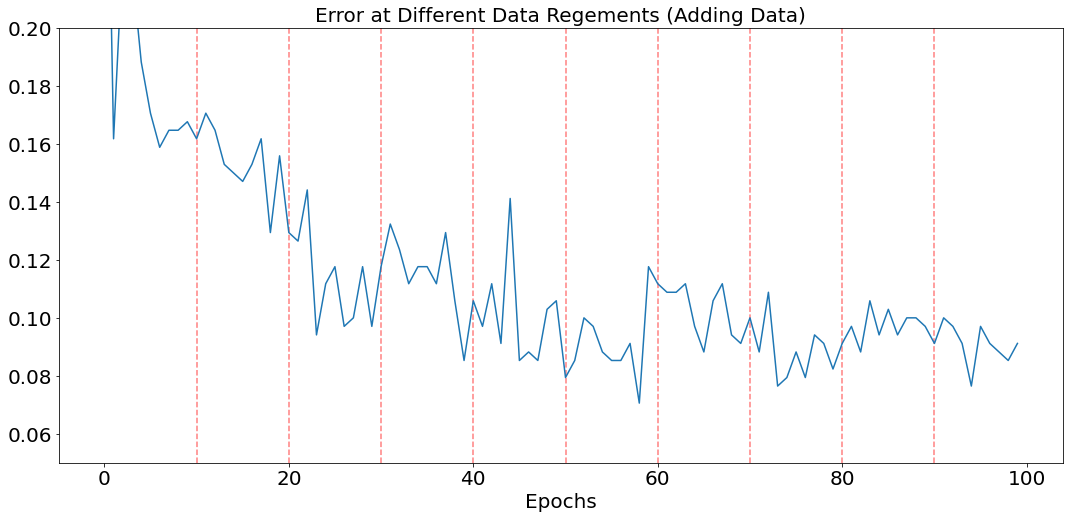

In [106]:
X = []
for i in range (1, int(total_epochs / 10)):
    X.append(i * 10)
fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.vlines(x = X, color = 'r', ymin = 0.05, ymax = 0.2, linestyle = "dashed", alpha = 0.5)
ax.plot(1 - np.array(val_acc))
ax.set_title("Error at Different Data Regements (Adding Data)",fontsize=20)
ax.set_xlabel("Epochs",fontsize=20)
ax.set_ylim(bottom = 0.05, top = 0.2)

In [98]:
subsets = getSubsets(compoundDataTrain, classTrain, .1)
curX = subsets[0][0]
curY = subsets[0][1]

l1Reg = keras.regularizers.L1(.001)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)


labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  curX, 
                                                        compoundDataTest, compoundDataValidate,
                                                        endDims=[1,1,9,4,6,7,3,16], muted = True)

labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

#after transformations are done assign data
dataLabels = labelsMaxPCA
trainData = trainMaxPCA
testData = testMaxPCA
valData = valMaxPCA

Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

accuracy = 0
while(accuracy < .7):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(2)
    ])

    model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

    
    history = model.fit(Xtrain, curY, validation_data = (valData, classVal), epochs=10, batch_size=4, verbose = 1)
    predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
    accuracy = np.mean(predictionsTrain == curY)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
total_epochs =  10
for i in range(1, len(subsets)):
    curX = subsets[i][0]
    curY = subsets[i][1]
    total_epochs += 10
    print("Data length:", len(curX))
    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  curX, 
                                                        compoundDataTest, compoundDataValidate,
                                                        endDims=[1,1,9,4,6,7,3,16], muted = True)

    labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

    labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
    _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
    _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

    #after transformations are done assign data
    dataLabels = labelsMaxPCA
    trainData = trainMaxPCA
    testData = testMaxPCA
    valData = valMaxPCA
    print("Epochs: ", total_epochs)
    print("Data length:", len(curX))
    
    Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)
    history = model.fit(Xtrain, curY,initial_epoch=total_epochs - 10, validation_data = (valData, classVal), epochs=total_epochs, batch_size=4, verbose = 1)
    
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']


Epoch 1/10
68/68 [==============================] - 1s 7ms/step - loss: 8.4384 - accuracy: 0.7048 - val_loss: 5.8104 - val_accuracy: 0.8529
Epoch 2/10
68/68 [==============================] - 0s 4ms/step - loss: 4.3209 - accuracy: 0.8672 - val_loss: 3.3071 - val_accuracy: 0.8500
Epoch 3/10
68/68 [==============================] - 0s 5ms/step - loss: 2.6612 - accuracy: 0.8967 - val_loss: 2.4468 - val_accuracy: 0.8265
Epoch 4/10
68/68 [==============================] - 0s 4ms/step - loss: 1.9394 - accuracy: 0.9225 - val_loss: 1.9760 - val_accuracy: 0.8294
Epoch 5/10
68/68 [==============================] - 0s 4ms/step - loss: 1.5264 - accuracy: 0.9520 - val_loss: 1.7034 - val_accuracy: 0.8588
Epoch 6/10
68/68 [==============================] - 0s 4ms/step - loss: 1.2982 - accuracy: 0.9410 - val_loss: 1.6288 - val_accuracy: 0.8412
Epoch 7/10
68/68 [==============================] - 0s 5ms/step - loss: 1.0945 - accuracy: 0.9631 - val_loss: 1.4628 - val_accuracy: 0.8588
Epoch 8/10
68/68 [==

(0.05, 0.2)

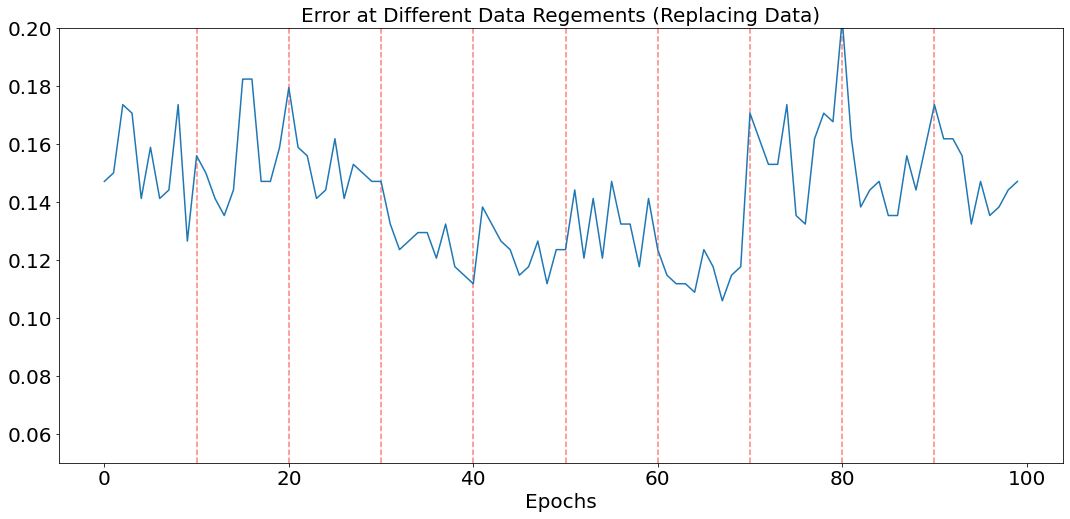

In [99]:
X = []
for i in range (1, int(total_epochs / 10)):
    X.append(i * 10)
fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.vlines(x = X, color = 'r', ymin = 0.05, ymax = 0.2, linestyle = "dashed", alpha = 0.5)
ax.plot(1 - np.array(val_acc))
ax.set_title("Error at Different Data Regements (Replacing Data)",fontsize=20)
ax.set_xlabel("Epochs",fontsize=20)
ax.set_ylim(bottom = 0.05, top = 0.2)